In [576]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import joypy as jp
import sympy as sym
from time import time
#sym.init_printing()

#from pysde import *
from functools import partial
from math import log
from matplotlib.colors import LogNorm
from scipy.integrate import odeint
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score

from collections import Counter


import seaborn as sns
sns.set()

In [2]:
R_t, gamma, R = sym.symbols('R_t gamma R')
2*R*gamma**2

2*R*gamma**2

In [3]:
sym.Derivative(32*gamma**2).doit()

64*gamma

In [4]:
gamma, r_R, h, l_R, eta, h, R_0 = sym.symbols('gamma r_R h l_R eta h R_0')
R_exp = (gamma*r_R*h/l_R - eta*h + 1)*R_0

In [411]:
gamma = 0.0138172

eta0 = 6.205e-6
phi0 = 6.205e-6

r_R = 63
r_P = 63
l_R = 5000
l_P = 975

T = 10000

R_t = []
P_t = []

h = 0.01

R_0, P_0 = 5773,2.11e6

In [599]:
618600*0.01

6186.0

In [595]:
div_time_volume(1e-18)

6186.3385578183

In [579]:
n_ribo_volume = lambda volume : (7.280245377599019e21*(1 + 1.3322199014570686e-12/
    volume**0.6454883435592754)*volume**0.6971221467560254)/(-5000*(1 +
1.3322199014570686e-12/volume**0.6454883435592754) + 
  1.3525663798553437e-6/volume**0.6454883435592754)

n_prot_volume = lambda volume : 7.466918335998994e18*(volume**0.6971221467560254)

div_time_volume = lambda volume : 1.4881390043125451e-8/volume**0.6454883435592754

def trajectories(V=1e-18, T=100000, n_traj=200):
    R_t = np.zeros((T, n_traj))
    P_t = np.zeros((T, n_traj))

    R_0 = n_ribo_volume(V)
    P_0 = n_prot_volume(V)

    R_0 = np.random.normal(R_0, 20, n_traj)
    P_0 = np.random.normal(P_0, 2e4, n_traj)

    for t in range(T): 
        eta = np.random.normal(eta0, 1e-3, n_traj)
        phi = np.random.normal(phi0, 1e-3, n_traj)

        R = (gamma*r_R*h/l_R - eta*h + 1)*R_0
        P = ((1-gamma)*r_P*h/l_P)*R_0 + (1-phi*h)*P_0

        R_t[t] = R
        P_t[t] = P

        R_0 = R
        P_0 = P

    return np.dstack((R_t, P_t))

def mutual_info(a, b, n=10000):
#     histoa, binsa = np.histogram(a, normed=True, bins=n)
#     histob, binsb = np.histogram(b, normed=True, bins=n)
#     histoab, binsmarga, binsmargb = np.histogram2d(a,b, normed=True, bins=n)

#     mutualinfo = 0

#     for i in range(len(histoa)):
#         px = (binsa[i+1]-binsa[i])*histoa[i]
#         for j in range(len(histob)):
#             py = (binsb[j+1]-binsb[j])*histob[j]

#             pxy = (binsa[i+1]-binsa[i])*(binsb[j+1]-binsb[j])* \
#                 histoab[i,j]
            
#             mutualinfo += pxy * log(pxy/px/py,2) if (px!=0 and py!=0 and pxy!=0) else 0

    histoab = np.histogram2d(a, b, n)[0]
    mutualinfo = mutual_info_score(None, None, contingency=histoab)
    return mutualinfo/np.log(2)

In [459]:
iterations = 200000
n_traj = 200

traj = [trajectory(1e-18,iterations) for x in range(n_traj)]

2113210.5002290057

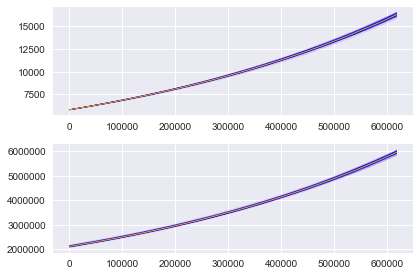

In [600]:
traj = trajectories(T=618600)
traj_avg = traj.mean(1)

fig, axes = plt.subplots(2)

for line in traj.transpose(1,2,0):
    axes[0].plot(line[0], linewidth=0.1, c='b', alpha=0.3)
    axes[1].plot(line[1], linewidth=0.1, c='b', alpha=0.3)

axes[0].plot(traj_avg.T[0], linewidth=1, c='orange')
axes[1].plot(traj_avg.T[1], linewidth=1, c='orange')
    
#plt.yscale('log')
plt.tight_layout()
plt.show()

In [601]:
iterations = 618600
fractions = 20
index_correction = np.zeros(fractions)
index_correction[-1] = -1
indices = (np.linspace(0,1,fractions)*iterations + index_correction).astype('int')

ribo_array_long = pd.melt(pd.DataFrame(traj[indices].transpose(2,0,1)[0]).T)
prot_array_long = pd.melt(pd.DataFrame(traj[indices].transpose(2,0,1)[1]).T)

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.


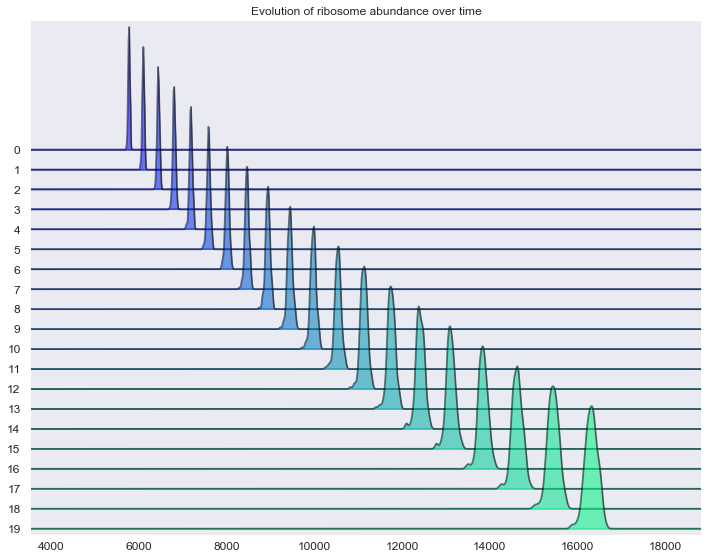

In [602]:
#merged_array_long
fig, axes = plt.subplots(2,figsize=(10,8))
jp.joyplot(ribo_array_long, by='variable', column='value', ylim='own', ax=axes[1], 
           alpha=0.55, colormap=cm.winter, overlap=2, title='Evolution of ribosome abundance over time')
plt.show()

/Users/nico/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


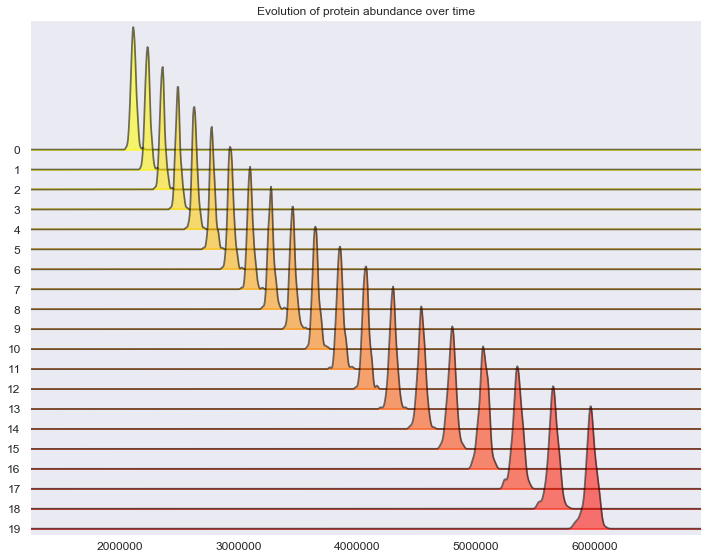

In [603]:
fig, axes = plt.subplots(2,figsize=(10,8))
jp.joyplot(prot_array_long, by='variable', column='value', ylim='own', ax=axes[1], 
           alpha=0.55, colormap=cm.autumn_r, overlap=2, title='Evolution of protein abundance over time')
plt.show()

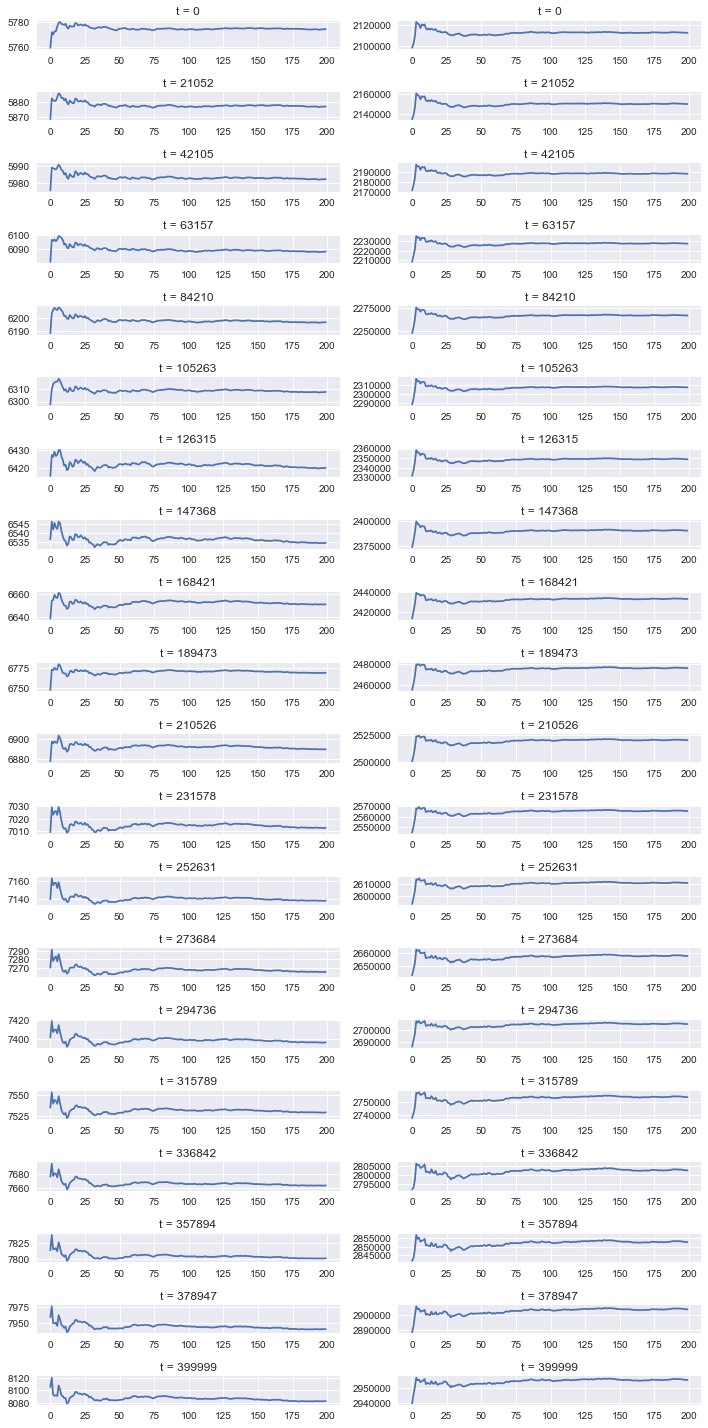

In [594]:
fig, axes = plt.subplots(fractions,2, figsize=(10,20))


for i in range(fractions):
    axes[i,0].plot(np.cumsum(ribo_array[i])/np.arange(1,n_traj+1))
    axes[i,1].plot(np.cumsum(prot_array[i])/np.arange(1,n_traj+1))
    axes[i,0].set_title('t = {}'.format(int(indices[i])))
    axes[i,1].set_title('t = {}'.format(int(indices[i])))

plt.tight_layout()
plt.show()

In [202]:
mutual_info(ribo_t0,ribo_t, 100)

5.896419225745976

In [77]:
timepoints = [ribo_t0, ribo_t1, ribo_t2, ribo_t3, ribo_tf]

mi_array = np.zeros((5,5))

for i,t1 in enumerate(timepoints):
    for j,t2 in enumerate(timepoints):
        mi_array[i,j] = mutual_info(t1,t2, n=100)

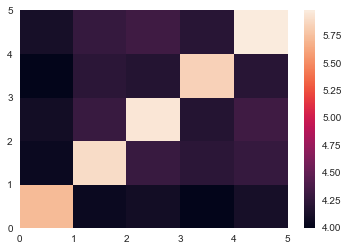

In [87]:
plt.pcolor(mi_array)
#plt.xticks(range(5), label=range(5,12))
plt.colorbar()

In [79]:
mi_array

array([[5.72772253, 4.05281758, 4.09333745, 3.99399366, 4.11191271],
       [4.05281758, 5.89895124, 4.29456616, 4.22522237, 4.27314141],
       [4.09333745, 4.29456616, 5.94947111, 4.18574224, 4.32366128],
       [3.99399366, 4.22522237, 4.18574224, 5.84012732, 4.2043175 ],
       [4.11191271, 4.27314141, 4.32366128, 4.2043175 , 5.97804637]])

In [112]:
#-np.sum(np.histogram(ribo_t0, density=True)[0] * np.vectorize(log)(np.histogram(ribo_t0, density=True)[0],2))

-3.2360704753786895

In [113]:
#np.vectorize(log)(np.histogram(ribo_t0, density=True)[0],2)

array([-2.47925804, -2.15732994,  0.22118168,  0.6082048 ,  1.10570446,
        0.76866948,  0.42763256, -1.30933304, -2.47925804, -3.47925804])

In [164]:
#np.histogram(ribo_t0, density=True, bins=100)[0]

In [160]:
#dir(sns.kdeplot(ribo_t0))

4.302255307356381

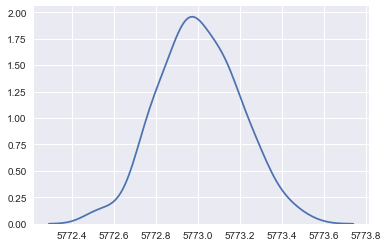

In [195]:
#dir(sns.kdeplot(ribo_t0).axes)
entropy(sns.kdeplot(ribo_t0).axes.lines[0].get_ydata())

In [185]:
entropy(np.array(list(Counter(ribo_t0).values()))/len(ribo_t0)) # calculates the probabilities
    

5.298317366548037

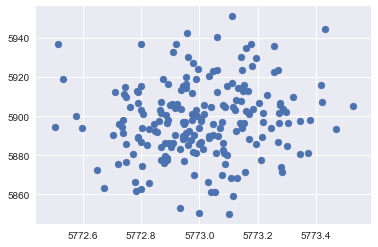

In [197]:
plt.scatter(ribo_t0, ribo_tf)

In [379]:
np.std(ribo_tf)

18.490566160273104

In [430]:
prot_array.shape

(20, 200)

In [604]:
J

NameError: name 'J' is not defined